## Convolutional Autoencoder as a Classifier with joint optimization for Liver Cancer Dataset

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

## Loading in the data

In [6]:
import keras
import math
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import metrics
from keras import losses
from keras.losses import mse
from keras.losses import mean_squared_error, categorical_crossentropy

## Data exploration

In [7]:
train_data = np.load('datasets_train/full_x.npy')
train_labels = np.load('datasets_train/full_y.npy')
val_data = np.load('datasets_val/full_x.npy')
val_labels = np.load('datasets_val/full_y.npy')
test_data = np.load('datasets_test/full_x.npy')
test_labels = np.load('datasets_test/full_y.npy')

In [8]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

print("Validation dataset (images) shape: {shape}".format(shape=val_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

#print(test_labels)
#print(test_data)
train_data.dtype, test_data.dtype
print(train_labels.shape)

Training set (images) shape: (1000, 256, 256, 3)
Validation dataset (images) shape: (200, 256, 256, 3)
Test set (images) shape: (200, 256, 256, 3)
(1000,)


In [9]:
# Create dictionary of target classes
label_dict = {
 0: 'non-viable',
 1: 'viable',
}

Text(0.5,1,'(Label: viable)')

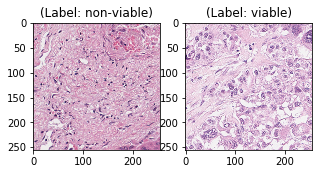

In [10]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[300], (256,256,3))
curr_lbl = train_labels[300]
plt.imshow(curr_img) #, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[100], (256, 256, 3))
curr_lbl = test_labels[100]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [11]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [12]:
train_X = train_data
valid_X = val_data
train_ground = train_labels
valid_ground = val_labels

## The Convolutional Autoencoder!

In [13]:
batch_size = 32 #64
epochs = 100 #200
inChannel = 3
x, y = 256, 256
input_img = Input(shape = (x, y, inChannel))
num_classes = 2 

W0718 14:25:48.493613 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 14:25:48.523810 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [14]:
"""
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4
"""

"\ndef encoder(input_img):\n    #encoder\n    #input = 28 x 28 x 1 (wide and thin)\n    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32\n    conv1 = BatchNormalization()(conv1)\n    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)\n    conv1 = BatchNormalization()(conv1)\n    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32\n    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64\n    conv2 = BatchNormalization()(conv2)\n    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)\n    conv2 = BatchNormalization()(conv2)\n    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64\n    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)\n    conv3 = BatchNormalization()(conv3)\n    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)\n    conv3 = BatchNormalization()(conv3)\n    conv4 = Conv2D(256, (3, 3), a

In [15]:
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)

W0718 14:25:59.549951 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 14:25:59.578017 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0718 14:25:59.579161 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0718 14:26:00.791979 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm 

In [16]:
def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

## The classifier

In [17]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
val_Y_one_hot = to_categorical(val_labels)
test_Y_one_hot = to_categorical(test_labels)
#test_Y_one_hot = test_Y_one_hot1[:100]

# Display the change for category label using one-hot encoding
print('Original label:', test_labels[150])
print('After conversion to one-hot:', test_Y_one_hot[150])

Original label: 1
After conversion to one-hot: [0. 1.]


In [18]:
train_label = train_Y_one_hot
valid_label = val_Y_one_hot

#train_label = train_labels
#valid_label = val_labels
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((1000, 256, 256, 3), (200, 256, 256, 3), (1000, 2), (200, 2))

In [19]:
def fc(conv4):
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4) # (small and thick)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool5)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool5) # (small and thick)
    conv6 = BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool6)
    conv6 = BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    flat = Flatten()(pool6)
    den = Dense(4096, activation='relu')(flat)
    den = Dropout(0.5)(den)
    den = Dense(4096, activation='relu')(den)
    den = Dropout(0.5)(den)
    den = Dense(256, activation='relu')(den)
    den = Dropout(0.5)(den)
    out = Dense(num_classes, activation='softmax')(den)
    #out = Dense(1, activation='sigmoid')(den) 
    return out

In [20]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [21]:
"""
# Custom loss (mean_squared_error + categorical_crossentropy)
def joint_loss(input_img, re_decode, train_label, cl_decode):
    img_flattened = K.flatten(input_img)
    re_decode_flattened = K.flatten(re_decode)
    RE = K.mse(img_flattened, re_decode_flattened)
    print(RE)



    CE = K.categorical_crossentropy(y_true, cl_decode)
    CE = K.expand_dims(CE)
    print(CE)

    
    
    #tensor1 = K.sum(RE)
    #tensor2 = K.sum(CE)
   
    tensor1 = K.sum(RE)
    tensor2 = K.sum(CE)
    print(tensor1)
    print(tensor2)
    

    divResult = Lambda(lambda x: x[0]/x[1])([tensor2,tensor1])
    print(divResult)
    
    WCE = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([CE, divResult])
    print(WCE)
    #WCE = divResult * CE
    WCE = K.sum(WCE)
    out = Lambda(lambda a: a[0] + a[1])([RE, WCE])
    #out = RE + c
    print(out)

    
    joint_loss = out
    return joint_loss
"""

'\n# Custom loss (mean_squared_error + categorical_crossentropy)\ndef joint_loss(input_img, re_decode, train_label, cl_decode):\n    img_flattened = K.flatten(input_img)\n    re_decode_flattened = K.flatten(re_decode)\n    RE = K.mse(img_flattened, re_decode_flattened)\n    print(RE)\n\n\n\n    CE = K.categorical_crossentropy(y_true, cl_decode)\n    CE = K.expand_dims(CE)\n    print(CE)\n\n    \n    \n    #tensor1 = K.sum(RE)\n    #tensor2 = K.sum(CE)\n   \n    tensor1 = K.sum(RE)\n    tensor2 = K.sum(CE)\n    print(tensor1)\n    print(tensor2)\n    \n\n    divResult = Lambda(lambda x: x[0]/x[1])([tensor2,tensor1])\n    print(divResult)\n    \n    WCE = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([CE, divResult])\n    print(WCE)\n    #WCE = divResult * CE\n    WCE = K.sum(WCE)\n    out = Lambda(lambda a: a[0] + a[1])([RE, WCE])\n    #out = RE + c\n    print(out)\n\n    \n    joint_loss = out\n    return joint_loss\n'

In [23]:
# Custom loss (mean_squared_error + categorical_crossentropy)
"""
def getLoss(input_img, re_decode):
    def w_categorical_crossentropy(y_true, cl_decode):
        img_flattened = K.flatten(input_img)
        re_decode_flattened = K.flatten(re_decode)
        RE = mse(img_flattened, re_decode_flattened)
        print(RE)



        CE = K.categorical_crossentropy(y_true, cl_decode)
        CE = K.expand_dims(CE)
        print(CE)

    
    
        #tensor1 = K.sum(RE)
        #tensor2 = K.sum(CE)
   
        tensor1 = K.sum(RE)
        tensor2 = K.sum(CE)
        print(tensor1)
        print(tensor2)
    

        divResult = Lambda(lambda x: x[0]/x[1])([tensor2,tensor1])
        print(divResult)
    
        WCE = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([CE, divResult])
        print(WCE)
        #WCE = divResult * CE
        WCE = K.sum(WCE)
        out = Lambda(lambda a: a[0] + a[1])([RE, WCE])
        #out = RE + c
        print(out)

    
        joint_loss = out
        return joint_loss   
    return w_categorical_crossentropy

"""

def joint_loss_v2(y_true, y_pred):
    img_flattened = K.flatten(y_true[0])
    re_decode_flattened = K.flatten(y_pred[0])
    RE = mse(img_flattened, re_decode_flattened)
    print(RE)



    CE = categorical_crossentropy(y_true[1], y_pred[1])
    CE = K.expand_dims(CE)
    print(CE)

    
    
    #tensor1 = K.sum(RE)
    #tensor2 = K.sum(CE)
   
    tensor1 = K.sum(RE)
    tensor2 = K.sum(CE)
    print(tensor1)
    print(tensor2)
    

    divResult = Lambda(lambda x: x[0]/x[1])([tensor2,tensor1])
    print(divResult)
    
    WCE = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([CE, divResult])
    print(WCE)
    #WCE = divResult * CE
    WCE = K.sum(WCE)
    out = Lambda(lambda a: a[0] + a[1])([RE, WCE])
    #out = RE + c
    print(out)

    
    joint_loss = out
    return joint_loss


In [17]:
# compile autoencoder part
#autoencoder = Model(input_img, re_decode)
#autoencoder.add_loss(joint_loss)
#autoencoder.compile(optimizer = RMSprop())
#autoencoder.summary()
#autoencoder.layers
#len(autoencoder.layers)

In [24]:
# Complie whole(recons-classifier) part

#part1 = encoder(input_img)
re_decode = decoder(conv4)

cl_decode = fc(conv4)

#loss = lambda input_img, re_decode: joint_loss(input_img, re_decode, y_true, cl_decode)

#jl = joint_loss(input_img, re_decode, cl_decode, train_label)
#print(jl)
full_model = Model(inputs = input_img, outputs = [re_decode, cl_decode])


#full_model.add_loss(joint_loss)
full_model.compile(optimizer='Adam', loss = joint_loss_v2, metrics=['accuracy'])
full_model.summary()
#full_model.layers
len(full_model.layers)

W0718 14:26:29.651586 139935759963904 deprecation_wrapper.py:119] From /home/mousumi/ENV_1/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Tensor("loss/conv2d_26_loss/Mean:0", shape=(), dtype=float32)
Tensor("loss/conv2d_26_loss/ExpandDims:0", shape=(256, 256, 1), dtype=float32)
Tensor("loss/conv2d_26_loss/Sum_2:0", shape=(), dtype=float32)
Tensor("loss/conv2d_26_loss/Sum_3:0", shape=(), dtype=float32)
Tensor("loss/conv2d_26_loss/lambda_1/truediv:0", shape=(), dtype=float32)
Tensor("loss/conv2d_26_loss/lambda_2/mul:0", shape=(256, 256, 1), dtype=float32)
Tensor("loss/conv2d_26_loss/lambda_3/add:0", shape=(), dtype=float32)
Tensor("loss/dense_8_loss/Mean:0", shape=(), dtype=float32)
Tensor("loss/dense_8_loss/ExpandDims:0", shape=(1,), dtype=float32)
Tensor("loss/dense_8_loss/Sum_2:0", shape=(), dtype=float32)
Tensor("loss/dense_8_loss/Sum_3:0", shape=(), dtype=float32)
Tensor("loss/dense_8_loss/lambda_4/truediv:0", shape=(), dtype=float32)
Tensor("loss/dense_8_loss/lambda_5/mul:0", shape=(1,), dtype=float32)
Tensor("loss/dense_8_loss/lambda_6/add:0", shape=(), dtype=float32)
________________________________________________

55

In [25]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

print(train_label.shape)
print(train_X.shape)
print(valid_label.shape)

(1000, 2)
(1000, 256, 256, 3)
(200, 2)


## Train the Model

In [26]:
def on_epoch_end(epoch, logs=None):
    print(K.eval(full_model.optimizer.lr))
    
var_GT = [train_X, train_label]
print(np.shape(var_GT[1]))
on_epoch_end(epoch=10, logs=None)
#autoencoder_train = autoencoder.fit(train_X,train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_X))
wholeModel_train = full_model.fit(train_X, [train_X, train_label], batch_size=,epochs=epochs,verbose=1,callbacks=callbacks_list, validation_data=(valid_X, [valid_X, valid_label]))

(1000, 2)
0.001


W0718 14:26:37.545582 139935759963904 deprecation.py:323] From /home/mousumi/ENV_1/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1000 samples, validate on 200 samples
Epoch 1/100
1000/1000 [==============================] - 21s 21ms/step - loss: 205768005049516.0312 - conv2d_26_loss: 205628790669.3120 - dense_8_loss: 205562383484475.8438 - conv2d_26_acc: 0.3811 - dense_8_acc: 0.4950 - val_loss: 165245239296.0000 - val_conv2d_26_loss: 165245239296.0000 - val_dense_8_loss: 2.9806 - val_conv2d_26_acc: 0.5177 - val_dense_8_acc: 0.4900
Epoch 2/100
1000/1000 [==============================] - 12s 12ms/step - loss: 168597899837.4400 - conv2d_26_loss: 168551440056.3200 - dense_8_loss: 46459468.3766 - conv2d_26_acc: 0.3866 - dense_8_acc: 0.4900 - val_loss: 123957895495.6800 - val_conv2d_26_loss: 123957895495.6800 - val_dense_8_loss: 18.8136 - val_conv2d_26_acc: 0.4145 - val_dense_8_acc: 0.5000
Epoch 3/100
1000/1000 [==============================] - 12s 12ms/step - loss: 125244590587.9040 - conv2d_26_loss: 125235439337.4720 - dense_8_loss: 9151315.7401 - conv2d_26_acc: 0.3630 - dense_8_acc: 0.4940 - val_loss: 89

Epoch 24/100
1000/1000 [==============================] - 12s 12ms/step - loss: 71172696047.6160 - conv2d_26_loss: 71172641652.7360 - dense_8_loss: 54575.0707 - conv2d_26_acc: 0.4565 - dense_8_acc: 0.5230 - val_loss: 48124747448.3200 - val_conv2d_26_loss: 48124747448.3200 - val_dense_8_loss: 5.9276 - val_conv2d_26_acc: 0.4678 - val_dense_8_acc: 0.5600
Epoch 25/100
1000/1000 [==============================] - 12s 12ms/step - loss: 63557021794.3040 - conv2d_26_loss: 63556931616.7680 - dense_8_loss: 90349.9056 - conv2d_26_acc: 0.4511 - dense_8_acc: 0.5130 - val_loss: 47991667261.4400 - val_conv2d_26_loss: 47991667261.4400 - val_dense_8_loss: 5.8068 - val_conv2d_26_acc: 0.4776 - val_dense_8_acc: 0.5500
Epoch 26/100
1000/1000 [==============================] - 12s 12ms/step - loss: 60681455075.3280 - conv2d_26_loss: 60670170398.7200 - dense_8_loss: 11284790.6293 - conv2d_26_acc: 0.4619 - dense_8_acc: 0.5380 - val_loss: 47877174067.2000 - val_conv2d_26_loss: 47877174067.2000 - val_dense_8_lo

1000/1000 [==============================] - 11s 11ms/step - loss: 66268725313.5360 - conv2d_26_loss: 66268670656.5120 - dense_8_loss: 54692.0998 - conv2d_26_acc: 0.4759 - dense_8_acc: 0.4960 - val_loss: 46903452958.7200 - val_conv2d_26_loss: 46903452958.7200 - val_dense_8_loss: 5.2304 - val_conv2d_26_acc: 0.5257 - val_dense_8_acc: 0.5000
Epoch 48/100
1000/1000 [==============================] - 11s 11ms/step - loss: 64735288950.7840 - conv2d_26_loss: 64735278137.3440 - dense_8_loss: 10832.3327 - conv2d_26_acc: 0.4801 - dense_8_acc: 0.5060 - val_loss: 46882256486.4000 - val_conv2d_26_loss: 46882256486.4000 - val_dense_8_loss: 5.1985 - val_conv2d_26_acc: 0.5287 - val_dense_8_acc: 0.5000
Epoch 49/100
1000/1000 [==============================] - 12s 12ms/step - loss: 59065214894.0800 - conv2d_26_loss: 59065210568.7040 - dense_8_loss: 4416.8381 - conv2d_26_acc: 0.4775 - dense_8_acc: 0.4990 - val_loss: 46911236341.7600 - val_conv2d_26_loss: 46911236341.7600 - val_dense_8_loss: 5.2131 - val_

1000/1000 [==============================] - 11s 11ms/step - loss: 63534145404.9280 - conv2d_26_loss: 63534072004.6080 - dense_8_loss: 73646.0015 - conv2d_26_acc: 0.4846 - dense_8_acc: 0.5030 - val_loss: 46520630640.6400 - val_conv2d_26_loss: 46520630640.6400 - val_dense_8_loss: 5.0258 - val_conv2d_26_acc: 0.5377 - val_dense_8_acc: 0.5000
Epoch 71/100
1000/1000 [==============================] - 12s 12ms/step - loss: 54930586435.5840 - conv2d_26_loss: 54930571427.8400 - dense_8_loss: 15152.8668 - conv2d_26_acc: 0.4850 - dense_8_acc: 0.5090 - val_loss: 46495948308.4800 - val_conv2d_26_loss: 46495948308.4800 - val_dense_8_loss: 5.0094 - val_conv2d_26_acc: 0.5391 - val_dense_8_acc: 0.5000
Epoch 72/100
1000/1000 [==============================] - 12s 12ms/step - loss: 17807346790793.2148 - conv2d_26_loss: 58619409301.5040 - dense_8_loss: 17748727627195.6836 - conv2d_26_acc: 0.4874 - dense_8_acc: 0.4860 - val_loss: 46526664212.4800 - val_conv2d_26_loss: 46526664212.4800 - val_dense_8_loss: 

1000/1000 [==============================] - 11s 11ms/step - loss: 60061984260.0960 - conv2d_26_loss: 60061983866.8800 - dense_8_loss: 464.8726 - conv2d_26_acc: 0.4877 - dense_8_acc: 0.5140 - val_loss: 46522165166.0800 - val_conv2d_26_loss: 46522165166.0800 - val_dense_8_loss: 4.5833 - val_conv2d_26_acc: 0.5401 - val_dense_8_acc: 0.5050
Epoch 94/100
1000/1000 [==============================] - 11s 11ms/step - loss: 58363958198.2720 - conv2d_26_loss: 58363944239.1040 - dense_8_loss: 13945.2154 - conv2d_26_acc: 0.4879 - dense_8_acc: 0.4820 - val_loss: 46512904765.4400 - val_conv2d_26_loss: 46512904765.4400 - val_dense_8_loss: 4.5962 - val_conv2d_26_acc: 0.5412 - val_dense_8_acc: 0.5050
Epoch 95/100
1000/1000 [==============================] - 11s 11ms/step - loss: 64089481543.6800 - conv2d_26_loss: 64089447858.1760 - dense_8_loss: 33800.2891 - conv2d_26_acc: 0.4898 - dense_8_acc: 0.5060 - val_loss: 46471922974.7200 - val_conv2d_26_loss: 46471922974.7200 - val_dense_8_loss: 4.5650 - val_c

In [27]:
full_model.save_weights('autoencoder_reconstr_classification_100epoch.h5')

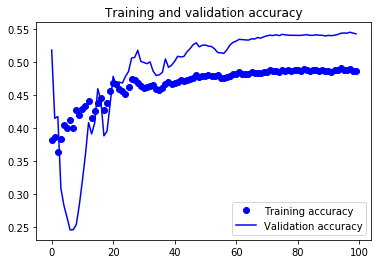

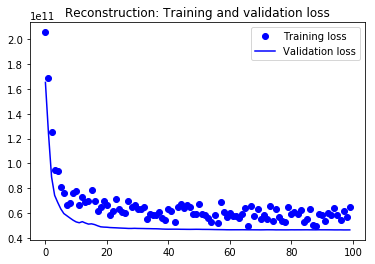

In [31]:
accuracy = wholeModel_train.history['conv2d_26_acc']
val_accuracy = wholeModel_train.history['val_conv2d_26_acc']
loss = wholeModel_train.history['conv2d_26_loss']
val_loss = wholeModel_train.history['val_conv2d_26_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Reconstruction: Training and validation loss')
plt.legend()
plt.show()

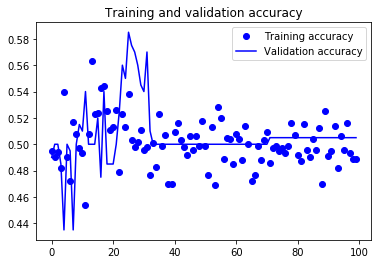

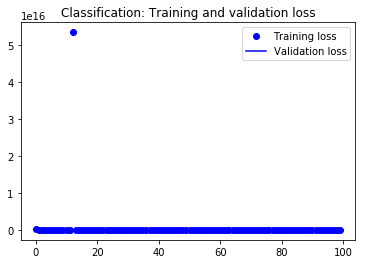

In [32]:
accuracy = wholeModel_train.history['dense_8_acc']
val_accuracy = wholeModel_train.history['val_dense_8_acc']
loss = wholeModel_train.history['dense_8_loss']
val_loss = wholeModel_train.history['val_dense_8_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Classification: Training and validation loss')
plt.legend()
plt.show()

In [36]:
test_eval = full_model.evaluate(test_data, [test_data, test_Y_one_hot], verbose=0)

In [37]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 66878776279.04
Test accuracy: 66878776279.04
